Let's first get all the roofs that have a roof:material OpenStreetMap(OSM) tag in Nepal. We will be using the Overpass API, which allows us to fetch data from OSM. More information about the Overpass API query language and other examples can be found here: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_API_by_Example.

In [ ]:
import overpy

api = overpy.Overpass()

# define query to get buildings with roof:material in Nepal, using the bounding box (26.347, 80.0585, 30.446, 88.2015)
# change the bounding box coordinates to get data from your desired study area (min latitude, min longitude, max latitude, max longitude)
query = """
[out:json][timeout:180];
(
  way["building"]["roof:material"](26.347, 83.5085, 30.446, 89.2015);
);
out body;
>;
out skel qt;
"""

response = api.query(query)

# extract building ids and roof materials
buildings = []
for way in response.ways:
    building = {
        "id": way.id,
        "roof_material": way.tags.get("roof:material", "unknown"),
        "geometry": [(float(node.lon), float(node.lat)) for node in way.nodes] #convert to float, because node.lon and node.lat are Decimal() objects by default
        #shapely expects longitude, latitude, in addition to GeoJSONS, even when WGS894 uses latitude, longitude
    }
    buildings.append(building)

# Oy
print(f"total buildings queried: {len(buildings)}")
print(f"first 4 buildings: {buildings[0:3]}")

total buildings queried: 26504
first 4 buildings: [{'id': 112551795, 'roof_material': 'metal', 'geometry': [(85.3093988, 27.7102375), (85.3091665, 27.7103155), (85.3091271, 27.7102236), (85.3091955, 27.7102006), (85.3091224, 27.7100299), (85.3090418, 27.710057), (85.3089893, 27.7099343), (85.3090648, 27.7099089), (85.3089769, 27.7097037), (85.3089221, 27.7097221), (85.3088871, 27.7096405), (85.3091026, 27.7095682), (85.309139, 27.7096532), (85.3090887, 27.7096701), (85.3091677, 27.7098548), (85.3092166, 27.7098383), (85.3092716, 27.7099668), (85.3092309, 27.7099805), (85.3093131, 27.7101726), (85.3093637, 27.7101556), (85.3093988, 27.7102375)]}, {'id': 120277868, 'roof_material': 'mixed', 'geometry': [(85.3121085, 27.7165969), (85.3118218, 27.7166264), (85.311798, 27.71661), (85.3117935, 27.7165781), (85.3117865, 27.7165282), (85.3117515, 27.716532), (85.3117413, 27.7164593), (85.3119327, 27.7164383), (85.3119189, 27.7163399), (85.3120623, 27.7163325), (85.3121085, 27.7165969)]}, {'id'

Next, we should convert the building geometries to a geopandas dataframe for future geospatial operations and to be able to better access/manipulate the data

In [6]:
import geopandas as gpd
from shapely.geometry import Polygon

# create a list of shapely Polygons with each building["geometry"] being a list of coordinates
geometries = [Polygon(building["geometry"]) for building in buildings]
roof_materials = [building["roof_material"] for building in buildings]

gdf = gpd.GeoDataFrame({"roof_material": roof_materials}, geometry=geometries)
gdf.set_crs(epsg=4326, inplace=True)

gdf["roof_material"] = gdf["roof_material"].str.strip().str.lower().replace({
    "concerte": "concrete", #correct mispelled and join similar categories
    "concrete;metal": "mixed",
    "metal;concrete": "mixed",
    "concrete;roof_tiles": "mixed",
    "metal;roof_tiles": "mixed",
    "clay_tiles": "roof_tiles",
})

category_counts = gdf["roof_material"].value_counts()
#print(category_counts[:20])

keep_materials = category_counts[category_counts > 150].index.tolist()
gdf_filtered = gdf[gdf['roof_material'].isin(keep_materials)]

output_file = "buildings.geojson"
gdf.to_file(output_file, driver="GeoJSON")

output_file_filtered = "filtered_categories_buildings.geojson"
gdf_filtered.to_file(output_file_filtered, driver="GeoJSON")
gdf.head()


,roof_material,geometry
0,metal,"POLYGON ((85.3094 27.71024, 85.30917 27.71032,..."
1,mixed,"POLYGON ((85.31211 27.7166, 85.31182 27.71663,..."
2,concrete,"POLYGON ((85.31047 27.71302, 85.31049 27.71249..."
3,concrete,"POLYGON ((85.35044 27.70559, 85.35041 27.70553..."
4,stone,"POLYGON ((85.32491 27.6737, 85.32488 27.67358,..."


In [10]:
osm_bbox = gdf.total_bounds
print(osm_bbox)

[83.9458364 26.4530155 89.0080111 29.2702637]


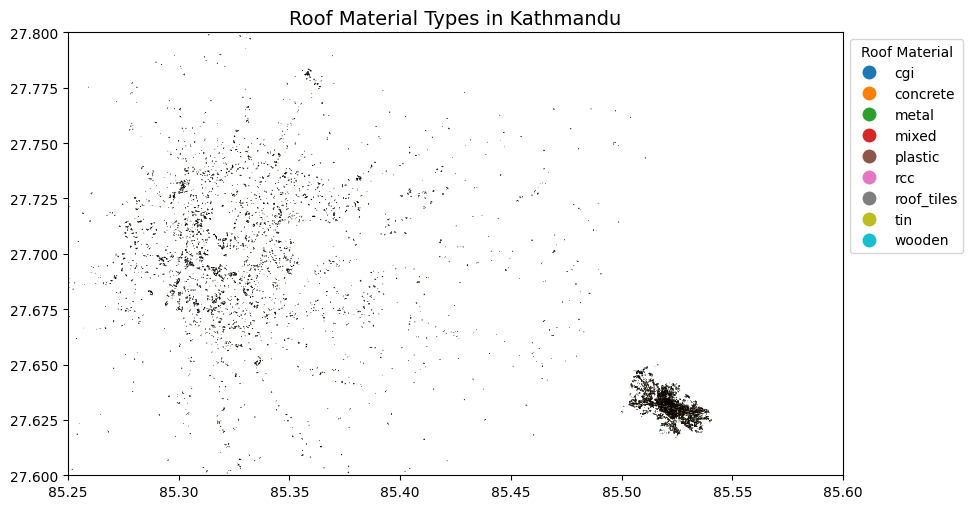

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

gdf_filtered.plot(
    ax=ax,
    column="roof_material",
    legend=True,
    legend_kwds={
        "title": "Roof Material",
        "bbox_to_anchor": (1, 1),
        "loc": "upper left"
    },
    edgecolor="black",
    linewidth=0.3,
    cmap="tab10"
)
ax.set_xlim(85.25, 85.6)
ax.set_ylim(27.6, 27.8)
ax.set_aspect('equal')
ax.set_title("Roof Material Types in Kathmandu", fontsize=14)

plt.show()